In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plot
from PIL import Image
import cv2
import random 
import seaborn as sns
import tensorflow as tf

In [2]:
clips_paths=[]
s=os.listdir('../input/aisegmentcom-matting-human-datasets/clip_img')
s=['../input/aisegmentcom-matting-human-datasets/clip_img/'+i for i in s]
k=[]
for i in s:
    a=os.listdir(i)
    b=[i+'/'+j for j in a]
    k.extend(b)
for i in k:
    a=os.listdir(i)
    b=[i+'/'+j for j in a]
    clips_paths.extend(b)
    

In [3]:
clips_paths[:5]

['../input/aisegmentcom-matting-human-datasets/clip_img/1803250146/clip_00000000/1803250146-00000420.jpg',
 '../input/aisegmentcom-matting-human-datasets/clip_img/1803250146/clip_00000000/1803250146-00000085.jpg',
 '../input/aisegmentcom-matting-human-datasets/clip_img/1803250146/clip_00000000/1803250146-00000148.jpg',
 '../input/aisegmentcom-matting-human-datasets/clip_img/1803250146/clip_00000000/1803250146-00000173.jpg',
 '../input/aisegmentcom-matting-human-datasets/clip_img/1803250146/clip_00000000/1803250146-00000132.jpg']

In [4]:
matting_paths=[]
s=os.listdir('../input/aisegmentcom-matting-human-datasets/matting')
s=['../input/aisegmentcom-matting-human-datasets/matting/'+i for i in s]
k=[]
for i in s:
    try:
        a=os.listdir(i)
        b=[i+'/'+j for j in a]
        k.extend(b)
    except:
        continue
for i in k:
    try:
        a=os.listdir(i)
        b=[i+'/'+j for j in a]
        matting_paths.extend(b)
    except:
        continue
    

In [5]:
matting_paths[:5]

['../input/aisegmentcom-matting-human-datasets/matting/1803250146/matting_00000000/1803250146-00000159.png',
 '../input/aisegmentcom-matting-human-datasets/matting/1803250146/matting_00000000/1803250146-00000217.png',
 '../input/aisegmentcom-matting-human-datasets/matting/1803250146/matting_00000000/1803250146-00000370.png',
 '../input/aisegmentcom-matting-human-datasets/matting/1803250146/matting_00000000/1803250146-00000047.png',
 '../input/aisegmentcom-matting-human-datasets/matting/1803250146/matting_00000000/1803250146-00000314.png']

In [6]:
from tqdm import tqdm
for i in tqdm(range(len(clips_paths))):
    clips_paths[i]=clips_paths[i].replace(clips_paths[i][-4:],'.jpg')
for j in tqdm(range(len(matting_paths))):
    matting_paths[j]=matting_paths[j].replace(matting_paths[j][-4:],'.jpg')

100%|██████████| 34426/34426 [00:00<00:00, 693964.10it/s]


In [7]:
image_paths=[]
masked_paths=[]

for i in tqdm(range(len(clips_paths))):
    a=clips_paths[i]
    
    b=a[:45]+'matting'+a[53:]
    b=b.replace('clip','matting')
    if b in matting_paths:
        try:
            p=cv2.imread(a)
            q=cv2.imread(b)
            image_paths.append(a)
            masked_paths.append(b)
        except:
            continue

100%|██████████| 34427/34427 [05:55<00:00, 96.97it/s] 


In [8]:
data=pd.DataFrame({'clip_paths':image_paths,'matted_paths':masked_paths})
data.head()

,clip_paths,matted_paths
0,../input/aisegmentcom-matting-human-datasets/c...,../input/aisegmentcom-matting-human-datasets/m...
1,../input/aisegmentcom-matting-human-datasets/c...,../input/aisegmentcom-matting-human-datasets/m...
2,../input/aisegmentcom-matting-human-datasets/c...,../input/aisegmentcom-matting-human-datasets/m...
3,../input/aisegmentcom-matting-human-datasets/c...,../input/aisegmentcom-matting-human-datasets/m...
4,../input/aisegmentcom-matting-human-datasets/c...,../input/aisegmentcom-matting-human-datasets/m...


In [9]:
x,y=data.clip_paths,data.matted_paths

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.13,random_state=42)

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(29950,)
(29950,)
(4476,)
(4476,)


In [11]:
def load_image(path):
    try:
        img=cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    except:
        path=path.replace(path[-4:],'.png')
        img=cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=cv2.resize(img,(256,256))
    return img

In [12]:
def convert_colors_to_classes(img):
    mask=np.zeros((256,256))
    img=np.sum(img,2)
    ind1=np.where(img<=3)
    
    mask[ind1[0],ind1[1]]=1
    return mask
    

In [13]:
def tr_data_generator(clip_path,matted_path, batch_size=16):
    while True:
        files=random.sample(list(zip(clip_path,matted_path)),15000)
        for i in range(0,15000, len(clip_path)//batch_size-1):
            #batch_img_files=clip_path[i:i+batch_size]
            #batch_mask_files=matted_path[i:i+batch_size]
            batch_files=files[i:i+batch_size]
            imgs=[]
            segs=[]
            for j in range(batch_size):
                image = load_image(batch_files[j][0])
                mask = load_image(batch_files[j][1])
                imgs.append(image)
                segs.append(convert_colors_to_classes(mask))

            yield np.array(imgs), np.array(segs)

In [14]:
def val_data_generator(clip_path,matted_path, batch_size=16):
    while True:
        for i in range(0,len(clip_path), len(clip_path)//batch_size-1):
            batch_img_files=clip_path[i:i+batch_size]
            batch_mask_files=matted_path[i:i+batch_size]
            imgs=[]
            segs=[]
            for j in range(batch_size):
                image = load_image(batch_img_files[j])
                mask = load_image(batch_mask_files[j])
                imgs.append(image)
                segs.append(convert_colors_to_classes(mask))

            yield np.array(imgs), np.array(segs)

In [15]:
train_gen=tr_data_generator(x_train.values,y_train.values)
valid_gen=val_data_generator(x_test.values,y_test.values)

In [16]:
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout,UpSampling2D,Conv2DTranspose
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate, add

In [17]:
def segnet():    
    input1=Input((256,256,3))
    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(input1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c1=BatchNormalization()(conv2)
    drop1 = Dropout(0.1)(c1)
    pool1 =MaxPooling2D(pool_size=(2, 2))(drop1)
    
    conv1=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    c2=BatchNormalization()(conv2)
    drop2 = Dropout(0.1)(c2)
    pool2 =MaxPooling2D(pool_size=(2, 2))(drop2) 
    
    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c3=BatchNormalization()(conv3)
    drop3 = Dropout(0.1)(c3)
    pool3 =MaxPooling2D(pool_size=(2, 2))(drop3) 
    
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c4=BatchNormalization()(conv3)
    drop4 = Dropout(0.1)(c4)
    pool4 =MaxPooling2D(pool_size=(2, 2))(drop4) 
    
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(pool4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    c5=BatchNormalization()(conv3)
    drop5 = Dropout(0.1)(c5)
    pool5 =MaxPooling2D(pool_size=(2, 2))(drop5) 
    

    
    up1 =Conv2D(1024,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(pool5))
    merge1 = concatenate([c5,up1], axis =3)
    
    conv1=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge1)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(1024,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    
    
    up2 =Conv2D(512,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge2 = concatenate([c4,up2], axis =3)
    
    conv1=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge2)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(512,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    

    up3 =Conv2D(256,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge3 = concatenate([c3,up3], axis =3)

    conv1=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge3)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    conv3=Conv2D(256,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch2)
    batch3=BatchNormalization()(conv3)
    

    up4 =Conv2D(128,2, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch3))
    merge4 = concatenate([c2,up4], axis =3) 

    conv1=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(merge4)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(128,2,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)
    
    
    up5 =Conv2D(64,1, activation = 'relu', padding = 'same',kernel_initializer='he_normal')(UpSampling2D(size = (2,2))(batch2))
    merge5 = concatenate([c1,up5], axis =3) 

    conv1=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(merge5)
    batch1=BatchNormalization()(conv1)
    conv2=Conv2D(64,3,activation='relu',padding='same',kernel_initializer='he_normal')(batch1)
    batch2=BatchNormalization()(conv2)  
    
    output=Conv2D(1,(1,1),activation='sigmoid')(batch2)
    
    model=Model(input1,output)
    model.compile(optimizer=keras.optimizers.Adam(lr=0.0001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=["accuracy"])
    return model

In [18]:
model=segnet()
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       batch_normalization[0][0]        
_______________________________________________________________________________________

In [66]:
history=model.fit_generator(train_gen,steps_per_epoch=15000 // 16,
        epochs=1,
        validation_data=valid_gen,
        validation_steps=x_test.shape[0]//16)

937/937 [==============================] - 757s 808ms/step - loss: 0.0555 - accuracy: 0.9825 - val_loss: 0.0530 - val_accuracy: 0.9842


Text(0.5, 1.0, 'Predicted Image')

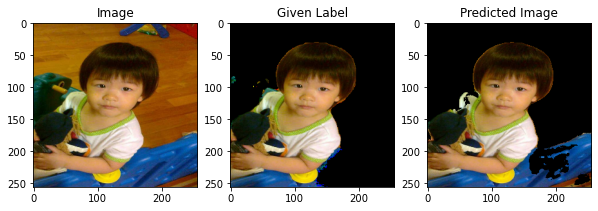

In [136]:
c=x_test.values
c_y=y_test.values

#c=['../input/backgrd-sample-imgs/2019-02-10-13-40-01-855.jpg','../input/backgrd-sample-imgs/pic1.jpeg','../input/backgrd-sample-imgs/vote.jpg']
#c=['../input/bgrd-sample-datset/WhatsApp Image 2020-08-28 at 11.34.50 AM.jpeg','../input/bgrd-sample-datset/WhatsApp Image 2020-08-28 at 11.34.51 AM (1).jpeg','../input/bgrd-sample-datset/WhatsApp Image 2020-08-28 at 11.34.51 AM.jpeg']
imk=25
r=load_image(c[imk])

a=r.reshape(1,256,256,3)
pred=model.predict(a)
pred=pred.reshape(256,256)
for i in range(3):
    for j in range(255):
        for k in range(255):
            if pred[j][k] > 0.5:
                r[j][k][i]=0
fig,ax=plot.subplots(1,3,figsize=(10,10))
ax[0].imshow(load_image(c[imk]))
ax[0].set_title('Image')
ax[1].imshow(load_image(c_y[imk]))
ax[1].set_title('Given Label')
ax[2].imshow(r)
ax[2].set_title('Predicted Image')